In [1]:
import rlssm
import pandas as pd
import os

#### Import the data of a single subject

In [2]:
data = pd.read_csv('../../data/data_experiment.csv', index_col=0)
data = data[data.participant == 10].reset_index(drop=True)

data.head()

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,10,1,1,61,52,4,3,1,1.285418,0
1,10,1,2,54,37,4,2,1,1.577622,0
2,10,1,3,51,51,4,3,2,1.564731,0
3,10,1,4,50,35,3,1,2,1.217245,1
4,10,1,5,59,50,4,2,3,1.929781,0


#### Initialise the model

In [3]:
model = rlssm.RLModel_2A(hierarchical_levels = 1)

Using cached StanModel


In [4]:
model.family, model.model_label, model.hierarchical_levels

('RL_2A', 'RL_2A', 1)

In [5]:
model.increasing_sensitivity, model.separate_learning_rates

(False, False)

#### Fit

In [6]:
# sampling parameters
n_iter = 500
n_chains = 2
n_thin = 1

# learning parameters
K = 4 # n options
initial_value_learning = 27.5 # intitial value (Q0)

# bayesian model
alpha_pos_priors = {'mu':0, 'sd':1}

In [7]:
model_fit = model.fit(data, 
                      K, 
                      initial_value_learning,
                      alpha_pos_priors = alpha_pos_priors,
                      print_diagnostics=False,
                      thin = n_thin,
                      iter_warmup = n_iter,
                      iter_sampling = n_iter)

Fitting the model using the priors:
alpha_priors {'mu': 0, 'sd': 1}
sensitivity_priors {'mu': 1, 'sd': 50}
alpha_pos_priors {'mu': 0, 'sd': 1}


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [8]:
model_fit.to_pickle()

Saving file as: /Users/khamir/_DecisionMaking/_Reports/_10/rlssm/tests/notebooks/RL_2A.pkl


#### get Rhat

In [9]:
model_fit.rhat.describe()

,rhat
count,482.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [10]:
model_fit.rhat.head()

,rhat,variable
name,,
lp__,1.0,lp__
alpha,1.0,alpha
sensitivity,1.0,sensitivity
log_p_t[1],NaN,log_p_t[1]
log_p_t[2],1.0,log_p_t[2]


#### get wAIC

In [11]:
model_fit.waic

{'lppd': -114.16720660413446,
 'p_waic': 1.545050070357352,
 'waic': 231.42451334898362,
 'waic_se': 16.345348878142826}

### Posteriors

In [12]:
model_fit.samples

,transf_alpha,transf_sensitivity
0,0.018251,0.599076
1,0.026386,0.364205
2,0.011982,0.841316
3,0.011982,0.841316
4,0.006506,1.321620
...,...,...
1995,0.000476,16.364600
1996,0.000490,16.319000
1997,0.001703,4.454920
1998,0.001818,4.669320


In [13]:
model_fit.trial_samples

{'log_p_t': array([[-0.693147  , -0.526685  , -0.520496  , ..., -0.0130624 ,
         -0.257472  , -0.260078  ],
        [-0.693147  , -0.545079  , -0.540586  , ..., -0.0361175 ,
         -0.324949  , -0.329315  ],
        [-0.693147  , -0.538486  , -0.531807  , ..., -0.0110589 ,
         -0.253394  , -0.254475  ],
        ...,
        [-0.693147  , -0.574147  , -0.567736  , ..., -0.0143995 ,
         -0.28597   , -0.284555  ],
        [-0.693147  , -0.561067  , -0.554034  , ..., -0.00884556,
         -0.255406  , -0.254002  ],
        [-0.693147  , -0.543716  , -0.538479  , ..., -0.0256665 ,
         -0.302125  , -0.305358  ]])}

In [14]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

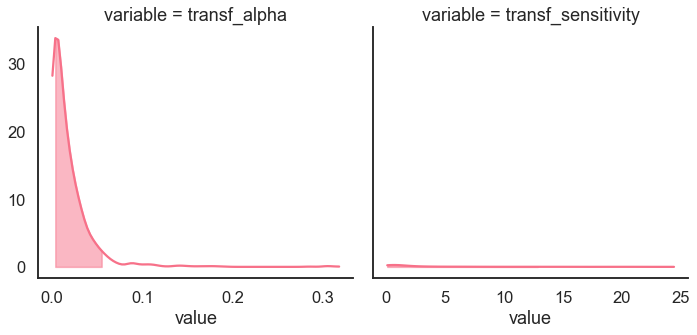

In [15]:
model_fit.plot_posteriors(height=5, show_intervals="HDI", alpha_intervals=.05);

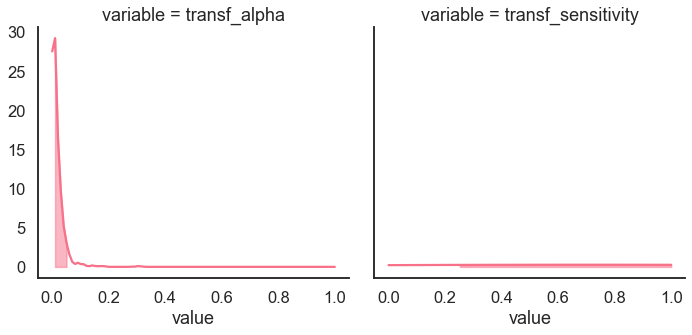

In [16]:
model_fit.plot_posteriors(height=5, show_intervals="BCI", alpha_intervals=.1, clip=(0, 1));

### Posterior predictives

#### Ungrouped

In [17]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=500)

pp

variable accuracy                                      ...                  \
trial         1   2   3   4   5   6   7   8   9   10   ... 230 231 232 233   
sample                                                 ...                   
1               0   0   0   1   1   1   0   1   1   1  ...   1   1   1   1   
2               0   1   1   1   0   1   0   1   1   1  ...   1   1   1   1   
3               0   0   1   1   1   1   1   1   0   1  ...   1   1   1   1   
4               1   0   1   1   1   1   0   1   1   0  ...   1   1   1   1   
5               0   0   1   1   1   1   0   1   1   0  ...   1   1   1   1   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
496             0   1   0   0   0   1   1   1   1   0  ...   1   1   1   1   
497             1   0   1   1   0   1   1   1   1   1  ...   1   1   1   1   
498             0   1   1   0   0   1   1   1   0   1  ...   1   1   0   1   
499             1   1   1   1   0   1   0   1   1   1  ...   1   1   1   1   
500             0   1   1   1   1   1   0   1   1   1  ...   1   1   1   1   

variable                          
trial    234 235 236 237 238 239  
sample                            
1          1   0   1   1   1   1  
2          1   1   1   1   0   1  
3          1   1   1   1   0   1  
4          1   1   1   1   1   1  
5          1   1   1   1   1   1  
...       ..  ..  ..  ..  ..  ..  
496        1   0   1   1   1   0  
497        1   1   1   1   1   1  
498        1   1   1   1   1   1  
499        1   0   1   1   0   1  
500        1   1   0   1   1   1  

[500 rows x 239 columns]

In [18]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=500)

pp_summary

,mean_accuracy
sample,
1,0.790795
2,0.744770
3,0.769874
4,0.740586
5,0.757322
...,...
496,0.782427
497,0.736402
498,0.761506


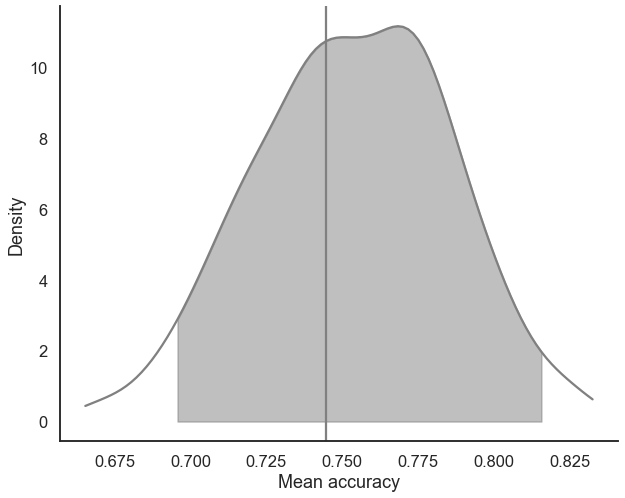

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

model_fit.plot_mean_posterior_predictives(n_posterior_predictives=500, ax=ax, show_intervals='HDI')

ax.set_ylabel('Density')
ax.set_xlabel('Mean accuracy')

sns.despine()

#### Grouped

In [20]:
import numpy as np

data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

data.head()

,index,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy,choice_pair,block_bins
0,0,10,1,1,61,52,4,3,1,1.285418,0,CD,1
1,1,10,1,2,54,37,4,2,1,1.577622,0,BD,1
2,2,10,1,3,51,51,4,3,2,1.564731,0,CD,1
3,3,10,1,4,50,35,3,1,2,1.217245,1,AC,1
4,4,10,1,5,59,50,4,2,3,1.929781,0,BD,1


In [21]:
model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['block_label', 'block_bins', 'choice_pair'], n_posterior_predictives=500)

mean_accuracy
block_label block_bins choice_pair sample               
1           1          AB          1                 1.0
                                   2                 1.0
                                   3                 0.0
                                   4                 0.0
                                   5                 0.0
...                                                  ...
3           8          BD          496               1.0
                                   497               1.0
                                   498               1.0
                                   499               1.0
                                   500               1.0

[46000 rows x 1 columns]

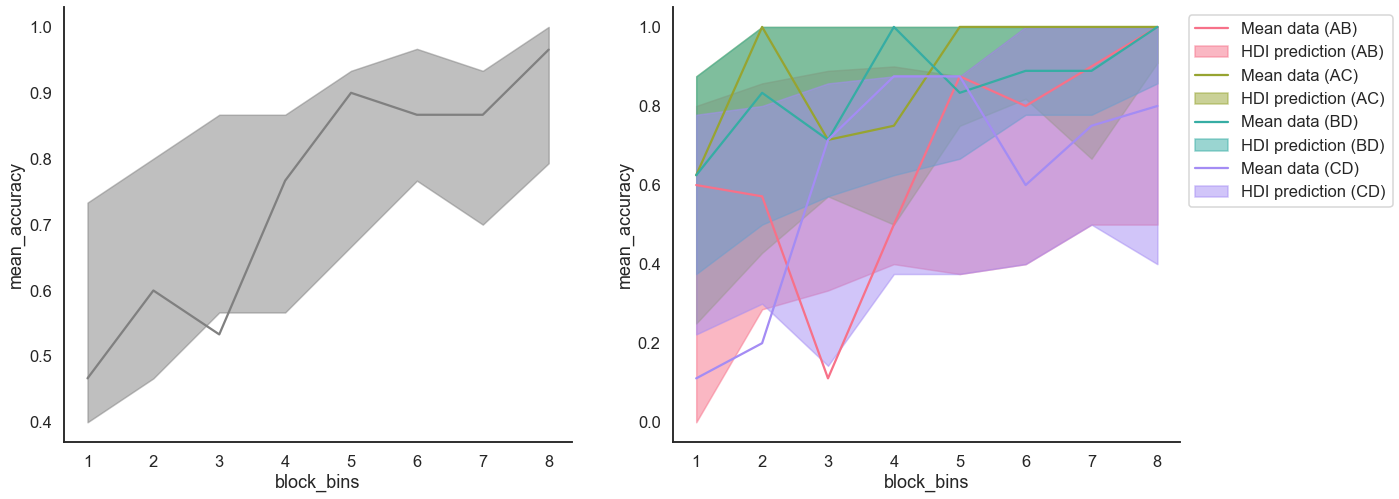

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20,8))

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], n_posterior_predictives=500, ax=axes[0])

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins', 'choice_pair'], n_posterior_predictives=500, ax=axes[1])

sns.despine()

### Get last values for eventual further sampling

In [23]:
# sv = model_fit.last_values
# sv